# Comal Springs Discharge Prediction Model
##### This workflow was written by Emily C. Pease to fulfill the requirement for Subsurface Machine Learning (PGE 383) Term Project instructed by Dr. Michael  Pyrcz
##### 12/06/2019


## This workflow contains two sections: (1) Feature Ranking/Feature Engineering and (2) Isotonic Regression and Model Accuracy during Edwards Aquifer Authority Drought Stages


### Executive Summary:

Here, the goal was to create a predictive machine learning model to estimate springflow discharge from Comal Springs using hydrological and meterological data in the region.  Feature ranking was performed and through this process, it was discovered that index well J-17 (located 26 miles from the spring orifice) is highly correlated with Comal Springs discharge.  To avoid multicollinearity and increase model stability, J-17 was used as the single predictor feature to model springflow using isotonic regression.  Model boosting using multiple linear regression and naive Bayes classification was attempted with the isotonic regression residuals in an attempt to explain more of the variance, but was unsucessful due to conditional independence between the residual and remaining predictor features. 

Next, the model accuracy was examined and characterized for each of the drought stages  set by the Edwards Aquifer Authority in the San Antonio region.  Theory-guided output post-processing was performed to create predictions that are consistent with the physical processes.  Springflow can never be larger than total river discharge.  Therefore, if springflow exceeded the daily river discharge, it was truncated and set equal to the discharge value.  After this correction, the accuracy was calculated, with a "correct" springflow value if the prediction fell between the P25 and P75 value (see box plot at bottom of workflow).  The accuracies are the following:

Drought stage 1: 81.6%

Drought stage 2: 82.5%

Drought stage 3: 86.6%

Drought stage 4: 88.5%

Drought stage 5: 95.4%

Being able to predict springflow with increasing accuracy as drought worsens is of benefit to water resource management.  San Antonio groundwater withdrawal limits are put in place depending on the well level at J-17, and making accurate predictions when Texans face drought conditions is more beneficial than predicting springflow when the springs are plentiful.  To continue this project, it would be interesting to attempt other methods to explain more of the variance.  However, this method performs extremely well and arguably as well as the current method used by the USGS.  


#### Python Code Acknowledgements:

Code snippets and workflows for feature selection and isotonic regression are courtesy of Michael Pyrcz (https://github.com/GeostatsGuy/PythonNumericalDemos)

Partial correlation function courtesty of Fabian Pedregosa-Izquierdo (f@bianp.net) with testing by Valentina Borghesani (valentinaborghesani@gmail.com)

# Part I: Feature Selection for Springflow Prediction

The Edwards Aquifer Authority (EAA) and all stakeholders need accurate and current springflow data in order to make informed decisions for Comal Springs, especially during drought periods when the endangered species that inhabit the springs are most at risk due to low water levels.  However, springflow is difficult to measure directly due to the complexity of numerous seeps and spring orifices and the intermittent presence of rainfall and runoff.  The U.S. Geological Survey (USGS) is the federal agency responsible for correctly measuring the daily spring discharge and the EAA is responsible for regulating discharge through groundwater pumping or withdrawal to ensure the springs are flowing above drought thresholds.  

The current method used by the USGS for measuring springflow at Comal Springs involves separating the springflow component from the streamflow, otherwise referred to as baseflow separation or hydrograph separation.  This method includes some manual estimation of springflow, making this method's results often subjective and time-consuming.  The USGS often needs up to three months to publicly release springflow estimates, though the EAA and other water resource managers need to make daily water use decisions, especially when the aquifer levels are close to drought stage thresholds.  Additionally, these springs are primarily modeled by the EAA using theory-based models to simulate pumping scenarios and drought scenarios.  Here, a springflow prediction model was created using a theory-guided data science approach as a viable option for water resource management. 


### Methods used for feature ranking here include:
1. Summary statistics
2. Visual inspection of scatter matrices and heat maps
3. Correlation coefficients
4. Model-based (LASSO)
5. Domain expertise

### Dataset Description

When performing statistical learning methods on big data, there is often a precompiled dataset containing all parameters for analysis. Here, there was no master dataset of all Edwards Aquifer data and all data used in this study were individually accessed from their respective agencies and  preprocessed prior to model runs.  The individual features selected to be included in the comprehensive Edwards Aquifer dataset are from the EAA, USGS, and National Oceanic and Atmospheric Administration (NOAA).  The time frame for this study is from 1950-01-01 to present using daily data that captures the two major droughts in recent history (1950-1956, 2011-2014). 

Predictor features:
1. J-17: Bexar County index well, located 24 miles from Comal Springs (EAA)
2. J-27: Uvalde County index well, located 106 miles from Comal Springs (EAA)
3. Q$_{riv}$: Comal River discharge ($\frac{ft^3}{s}$) recorded on 15-minute intervals that were then averaged together (USGS)
4. T$_{max}$: maximum recorded daily temperature (NOAA)
5. T$_{min}$: minimum recorded daily temperature (NOAA)
6. $\Delta$ T: daily change in temperature (T$_{max}-$T$_{min}$) (NOAA)
7. P$_{RM}$: trailing rolling mean of preciptiation (t=3 days) (NOAA)

Response feature:
1. Q$_{spg}$: Comal Springs daily mean discharge (USGS)

In [18]:
import geostatspy.GSLIB as GSLIB          
import geostatspy.geostats as geostats 
import numpy as np                     
import pandas as pd                     
import os                           
import matplotlib.pyplot as plt          
from scipy import stats                   
import math                               
import scipy.signal as signal             
import random                             
import seaborn as sns                     
from scipy import linalg     
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE 
from sklearn.linear_model import Lasso                   
from sklearn.model_selection import train_test_split        
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression 
from pylab import *
plt.style.use('ggplot')

##### Let's define some initial functions to assist in feature ranking

In [19]:
"""
Partial Correlation in Python
This uses the linear regression approach to compute the partial correlation. 
The algorithm is detailed here:
    http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
the algorithm can be summarized as
   1) perform a normal linear least-squares regression with X as the target and Z as the predictor
   2) calculate the residuals in Step #1
   3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
   4) calculate the residuals in Step #3
   5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
   The result is the partial correlation between X and Y while controlling for the effect of Z

Date: Nov 2014
Author: Fabian Pedregosa-Izquierdo, f@bianp.net
Testing: Valentina Borghesani, valentinaborghesani@gmail.com
"""

def partial_corr(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [20]:
def histograms(df, output, title):

    j17min = min(df['J17Level']); j17max = max(df['J17Level']); 
    j17name = r'J-17'; j17title = 'Index Well J-17'
    j27min = min(df['J27Level']); j27max = max(df['J27Level']);
    j27name = r'J-27'; j27title = 'Index Well J-27'     
    rvmin = min(df['RvQ']); rvmax = max(df['RvQ']);
    rvname = r'Q$_{riv}$'; rvtitle = 'Comal River Discharge'
    prmmin = min(df['RollingMean']); prmmax = max(df['RollingMean']);
    prmname = r'P$_{RM}$'; prmtitle = 'Precipitation Rolling Mean'
    TMAXmin = min(df['TMAX']); TMAXmax = max(df['TMAX']);
    TMAXname = r"$T_{max}$"; TMAXtitle = 'Maximum Temperature' 
    TMINmin = min(df['TMIN']); TMINmax = max(df['TMIN']);
    TMINname = r'$T_{min}$'; TMINtitle = 'Minimum Temperature'
    deltmin = min(df['DeltaT']); deltmax = max(df['DeltaT']);
    deltname = '$\Delta$T'; delttitle = 'Change in Temperature'
    spgqmin = min(df['SpgQ']); spgqmax = max(df['SpgQ']);
    spgqname = r'Q$_{spg}$'; spgqtitle = 'Comal Springflow Discharge'

    f, axs = plt.subplots(2,2,figsize=(15,15))
    plt.subplot(331)
    GSLIB.hist_st(df['J17Level'].values,j17min,j17max,log=False,cumul = False,
                  bins=20,weights = None,xlabel=j17name,title=j17title)

    plt.subplot(332)
    GSLIB.hist_st(df['J27Level'].values,j27min,j27max,log=False,cumul = False,
                  bins=20,weights = None,xlabel=j27name,title=j27title)
    
    plt.subplot(333)
    GSLIB.hist_st(df['RvQ'].values,rvmin,rvmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=rvname,title=rvtitle)

    plt.subplot(334)
    GSLIB.hist_st(df['RollingMean'].values,prmmin,prmmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=prmname,title=prmtitle)

    plt.subplot(335)
    GSLIB.hist_st(df['TMAX'].values,TMAXmin,TMAXmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=TMAXname,title=TMAXtitle)

    plt.subplot(336)
    GSLIB.hist_st(df['TMIN'].values,TMINmin,TMINmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=TMINname,title=TMINtitle)

    plt.subplot(337)
    GSLIB.hist_st(df['DeltaT'].values,deltmin,deltmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=deltname,title=delttitle)
    
    plt.subplot(338)
    GSLIB.hist_st(df['SpgQ'].values,spgqmin,spgqmax,log=False,cumul = False,bins=20,
                  weights = None,xlabel=spgqname,title=spgqtitle)

    fig = gcf()
    fig.suptitle(f"{title}", fontsize=18, y=1.05)
    fig.tight_layout()   
    plt.show()

In [21]:
df = pd.read_csv(os.path.join("ComalPrecipRolling.csv"))
df.rename(columns={'rolling_mean': 'RollingMean'}, inplace=True)

df = df[["J17Level", "J27Level", "RvQ", "RollingMean", "TMAX", "TMIN", "DeltaT", "SpgQ"]]
df.head()

,J17Level,J27Level,RvQ,RollingMean,TMAX,TMIN,DeltaT,SpgQ
0,664.21,871.15,286.0,0.133333,67.0,55.0,12.0,286.0
1,664.30,871.25,290.0,0.122667,71.0,53.0,18.0,290.0
2,663.99,871.25,286.0,0.035333,71.0,57.0,14.0,286.0
3,663.50,871.25,282.0,0.030000,67.0,27.0,40.0,282.0
4,663.47,871.25,282.0,0.026000,30.0,27.0,3.0,282.0


##### Summary Statistics

Values outside the typical physical range were truncated with the assumption that gauging stations malfunctioned and that outliers are not helpful in describing the system.  Comal River was truncated at Q$_{riv} < 800$ cfs and values less than 0 were removed from $\Delta$T.

In [22]:
df = df[df["RvQ"] < 800]   # Truncate to remove outliers
df = df[df["DeltaT"] >= 0] # Truncate to remove outliers

df.describe().T

,count,mean,std,min,25%,50%,75%,max
J17Level,23802.0,663.104604,17.412985,612.51,6.509493e+02,664.700000,676.350000,703.31
J27Level,23802.0,866.980272,16.240482,810.95,8.637000e+02,872.350000,877.417500,889.05
RvQ,23802.0,281.172574,99.758576,5.50,2.180000e+02,290.000000,347.000000,793.00
RollingMean,23802.0,0.086917,0.200663,0.00,2.826443e-15,0.003333,0.075556,4.18
TMAX,23802.0,78.120977,14.270323,17.00,6.900000e+01,80.000000,90.000000,109.00
TMIN,23802.0,53.491681,15.224556,-1.00,4.100000e+01,56.000000,67.000000,84.00
DeltaT,23802.0,24.629296,8.848741,0.00,1.900000e+01,24.000000,31.000000,69.00
SpgQ,23802.0,276.218027,94.605254,0.00,2.150000e+02,290.000000,345.000000,513.00


##### Bivariate Relationships: Correlation Scatter Matrix

The Pearson's correlation scatter matrix provides a visualization of the linearity in the bivariate relationships.  The temperature predictor features all exhibit a low degree of linearity with springflow, with T$_{max}$ showing the most linear relationship.  The linear relationship between index well J-17 and Q$_{spg}$ is the strongest among all the predictor features, but both Q$_{riv}$ and J-27 also have a strong linear relationship with Q$_{spg}$.  The remaining predictor features have little to no visible linear relationship with Q$_{spg}$. 

Text(0.5, 1.03, 'Correlation Scatter Matrix')

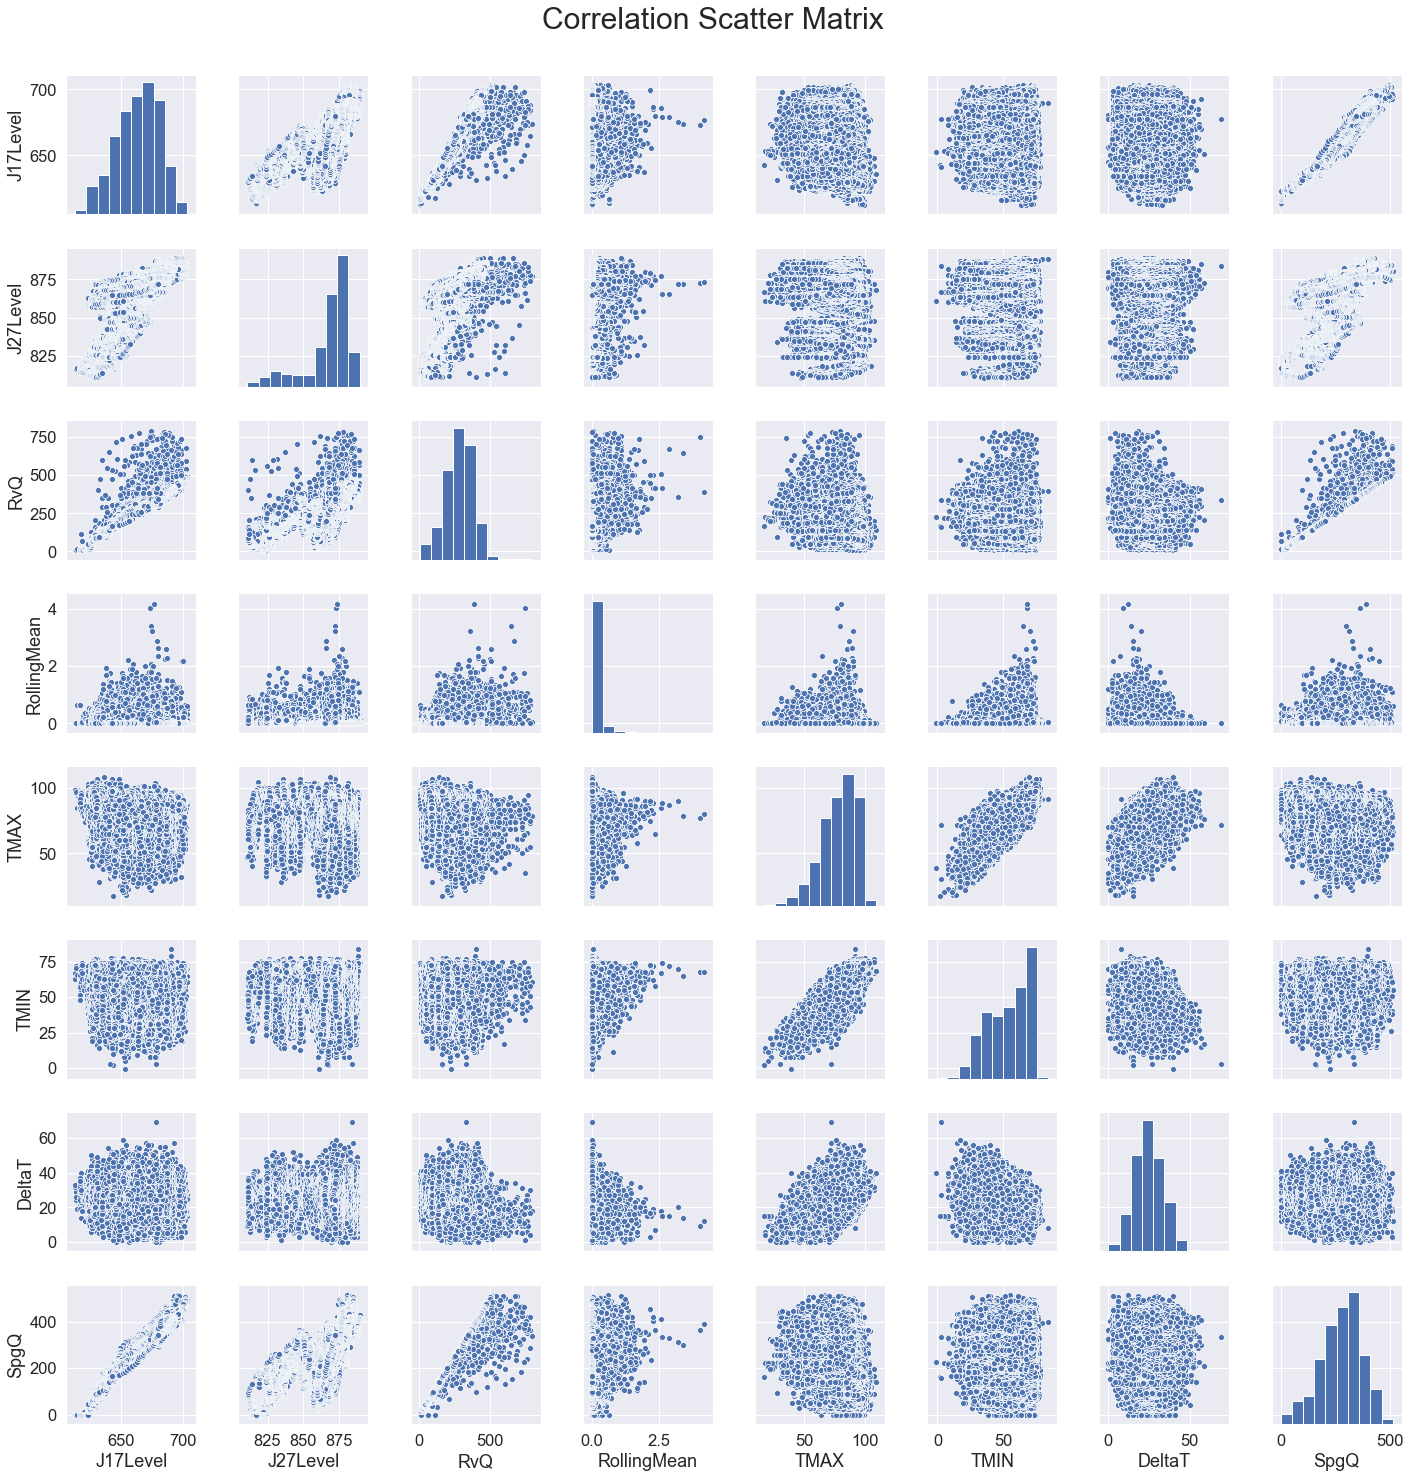

In [23]:
sns.set(font_scale=1.5) 
g = sns.pairplot(df, vars=df, markers='o')
g.fig.suptitle("Correlation Scatter Matrix", size=30, y=1.03)

In [24]:
# Calculate correlation, rank correlation, and partial correlation coefficients

correlation = df.corr().iloc[-1,:-1]
rank_correlation, rank_correlation_pval = stats.spearmanr(df) 
rank_correlation = rank_correlation[:,-1][:-1]
rank_correlation_pval = rank_correlation_pval[:,-1][:-1]
partial_correlation = partial_corr(df) 
partial_correlation = partial_correlation[:,-1][:-1]
rank_correlation_scatter, rank_correlation_pval = stats.spearmanr(df) 

### Pearson's Correlation, Spearman Rank Correlation, and Partial Correlation Coefficients

**Pearson's Correlation**: The Pearson correlation coefficient (Pearson's r) quantifies the linear relationsip between two features.  

**Spearman Rank Correlation**: The Spearman rank correlation coefficient ($\rho$) is similar to the Pearson correlation coefficient, but is more robust to outliers.  Notice that the Pearson's r for Q$_{riv}$ is very similar to the Spearman rank coefficient.  However, if the RvQ truncation is commented out, there will exist a significant difference in Q$_{riv}$ between the Pearson correlation and Rank correlation below due to the outliers.  

**Partial Correlation**: The partial correlation coefficient quantifies the usefulness of a feature in predicting the response when the impact of other precictor features is removed.  It is unexpected to find that index well J-27 is indeed negatively correlated with springflow discharge when the impact of other features is removed.  When examining the scatter matrix (above) between J-27 and springflow, they exhibit a strong positive linear correlation.


The Pearson's product-moment correlation ($r$), Spearman rank correlation ($\rho$), and the partial correlation (PC) coefficients were calculated between each predictor feature and the Q$_{spg}$.  Each predictor feature's $r$ and $\rho$ have a relatively similar coefficient, indicating there are very few outliers in the predictor features.  Index well J-27 has a positive $r$ of 0.75 and a $\rho$ of 0.79 but has a PC of -0.18, indicating that index well J-27 is negatively related to Comal Springs discharge values when the influences of confounding variables are removed.  P$_{RM}$ has very small $r$ and $\rho$ values with a much larger PC of -0.35.  Though the temperature features (T$_{max}$, T$_{min}$, and $\Delta$T) all have low coefficients, T$_{max}$ is more useful than the other temperature data according to the $r$ and $\rho$ (-0.20 and -0.21, respectively).  

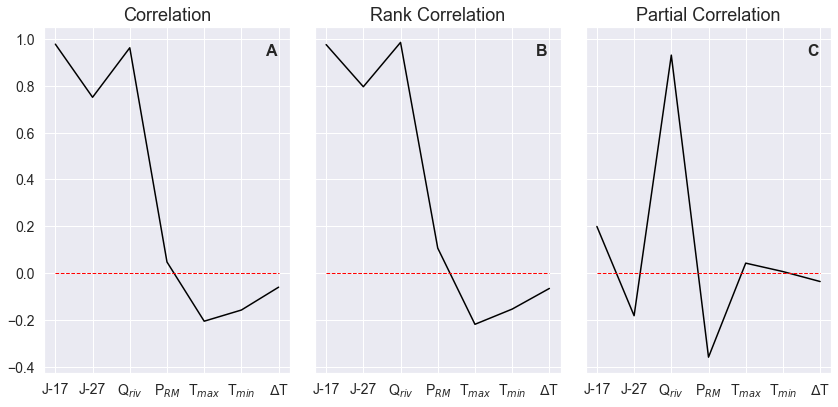

In [25]:
fig, axes = plt.subplots(1,3, figsize=(12,6), sharey=True)
features = df.columns.values[:-1]
labels = ['J-17', 'J-27', 'Q$_{riv}$', 'P$_{RM}$', r'T$_{max}$', r'T$_{min}$', r'$\Delta$T']

axes[0].set_xticklabels(labels);axes[1].set_xticklabels(labels);axes[2].set_xticklabels(labels)

axes[0].plot(features,correlation,color='black')
axes[0].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[0].set_title('Correlation')

axes[1].plot(features,rank_correlation,color='black')
axes[1].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[1].set_title('Rank Correlation')

axes[2].plot(features,partial_correlation,color='black')
axes[2].plot([0,0,0,0,0,0,0],'r--',color='red',linewidth = 1.0);axes[2].set_title('Partial Correlation')

axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=14)

axes[0].text(5.65, 0.98, 'A', fontsize=16, fontweight='bold', va='top')
axes[1].text(5.65, 0.98, 'B', fontsize=16, fontweight='bold', va='top')
axes[2].text(5.65, 0.98, 'C', fontsize=16, fontweight='bold', va='top')

fig.tight_layout()

### Heat Maps

Pearson correlation and Spearman rank correlation heat maps were used in addition to the correlation scatter matrix to visualize $r$ and $\rho$.  It is again clear through both heat map figures that index well J-17, Q$_{riv}$, and J-27 have strong linear relationships with springflow.  The rank correlation coefficients are often larger than the Pearson correlation coefficients because $\rho$ is more robust to outliers than $r$. 

(8, 0)

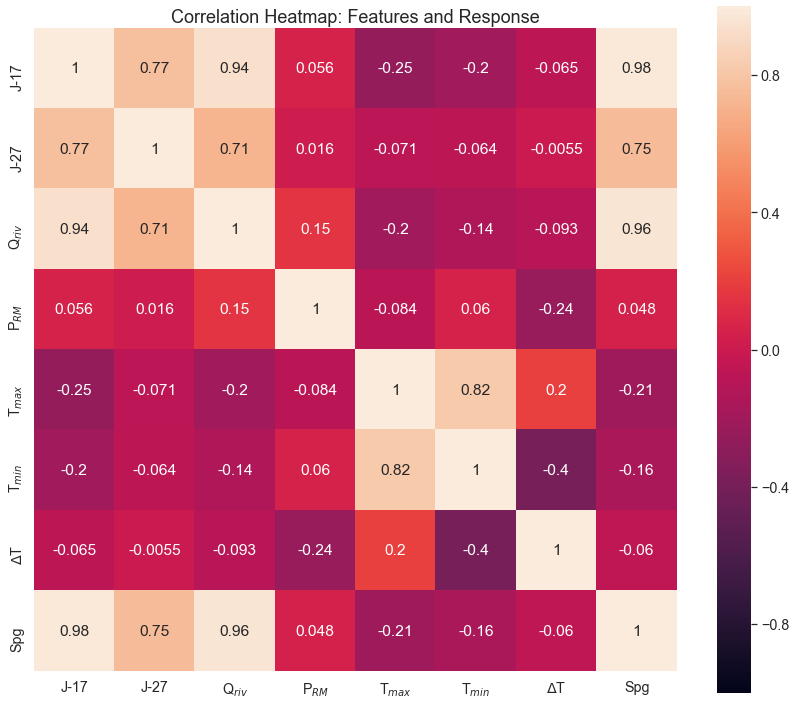

In [26]:
sns.set(font_scale=1.3) 
plt.figure(figsize=(12,10))

xticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]
yticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]

sns.heatmap(df.corr(), annot=True, linewidth=0, vmin=-1, square=True, xticklabels=xticks, yticklabels=yticks)
plt.title("Correlation Heatmap: Features and Response", size=18)
plt.tight_layout()
plt.ylim([8,0])

(8, 0)

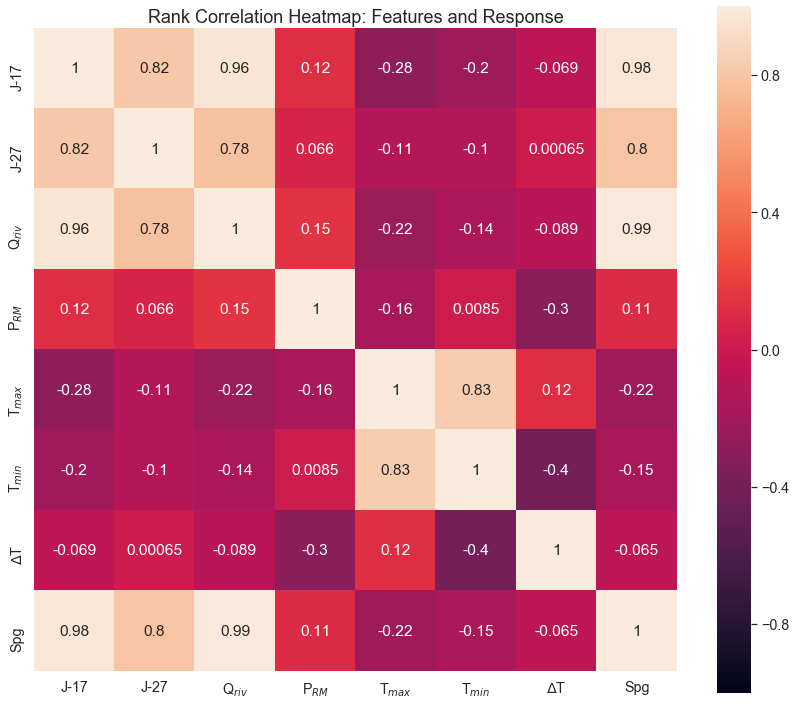

In [27]:
sns.set(font_scale=1.3) 
plt.figure(figsize=(12,10))

xticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]
yticks = ["J-17", "J-27", "Q$_{riv}$", "P$_{RM}$", r"T$_{max}$", r"T$_{min}$", r"$\Delta$T", "Spg"]

sns.heatmap(rank_correlation_scatter, annot=True, linewidth=0, vmin=-1, square=True, 
            xticklabels=xticks, yticklabels=yticks)
plt.title("Rank Correlation Heatmap: Features and Response", size=18)
plt.tight_layout()
plt.ylim([8, 0])

### Histograms: Univariate distributions

It can be useful to visualize the distributions of all features.  The P$_{RM}$ has many small values which is expected in the dry, Texas climate.  Index well J-17 follows a very similar distribution to Q$_{spg}$.  Index well J-27 is located further from Comal Springs than J-17 and exhibits a much different distribution, especially in low values.  

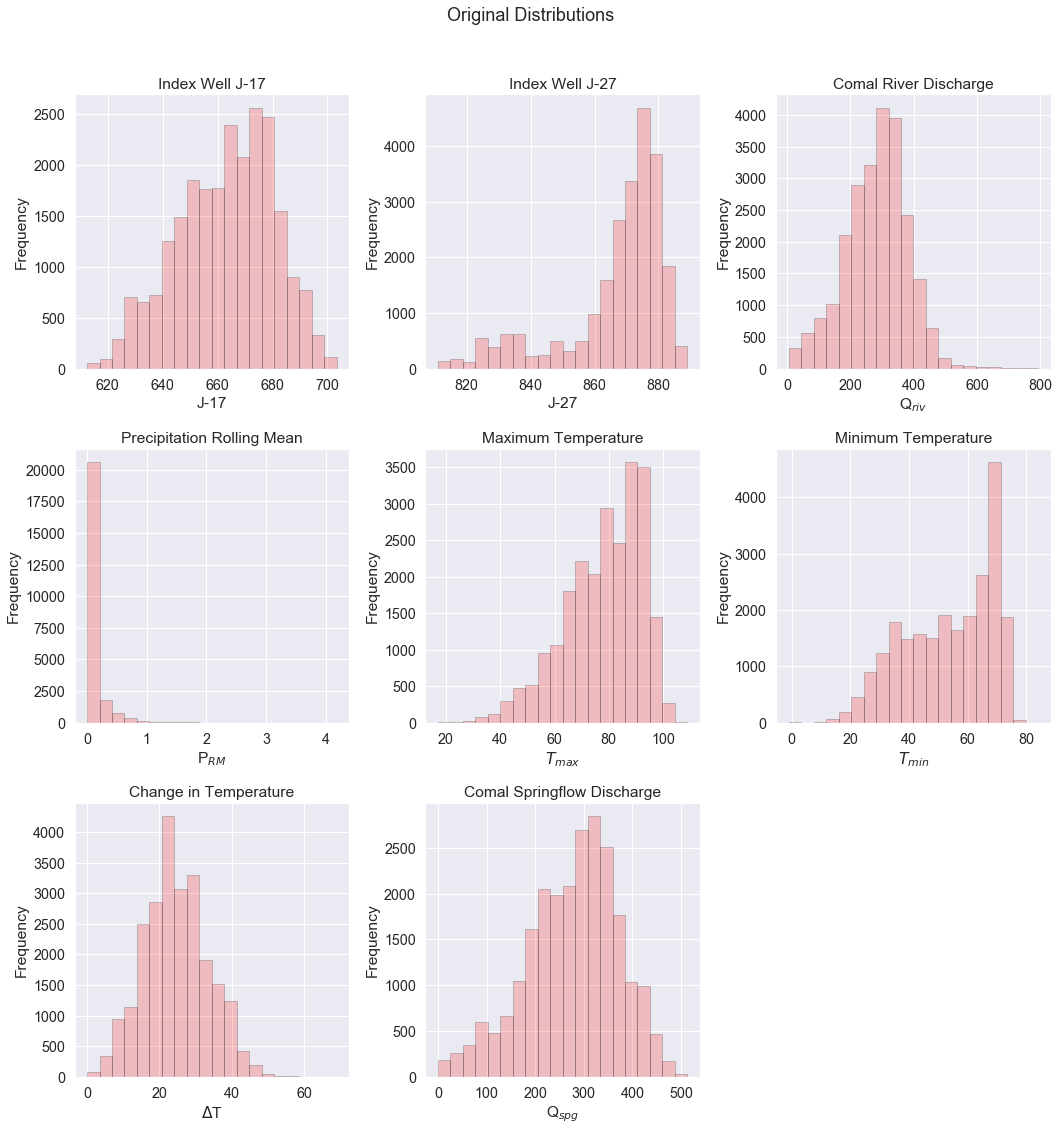

In [28]:
histograms(df, "Histograms_OriginalData.png", title='Original Distributions') 

### LASSO Model-Based Feature Selection

##### First, all predictor and response features must be standardized ($\sigma$=1, mean=0).  

The summary statistics are examined to ensure the data were properly transformed.

In [29]:
scaler = StandardScaler()                                   
sfeatures = scaler.fit_transform(df.values)             
df_st = pd.DataFrame(sfeatures, index=df.index, columns=df.columns) 
df_st.describe().T                                               

,count,mean,std,min,25%,50%,75%,max
J17Level,23802.0,5.979998e-15,1.000021,-2.905629,-0.698077,0.091623,0.760678,2.308980
J27Level,23802.0,5.521468e-15,1.000021,-3.450110,-0.201985,0.330645,0.642681,1.358962
RvQ,23802.0,-4.680829e-16,1.000021,-2.763455,-0.633268,0.088490,0.659881,5.130769
RollingMean,23802.0,9.612417e-17,1.000021,-0.433158,-0.433158,-0.416546,-0.056621,20.398221
TMAX,23802.0,-3.247922e-16,1.000021,-4.283173,-0.639170,0.131676,0.832446,2.163908
TMIN,23802.0,1.003035e-16,1.000021,-3.579272,-0.820513,0.164758,0.887290,2.003931
DeltaT,23802.0,1.098562e-16,1.000021,-2.783426,-0.636183,-0.071118,0.719971,5.014458
SpgQ,23802.0,-1.910543e-16,1.000021,-2.919751,-0.647103,0.145682,0.727057,2.502894


The LASSO (least absolute shrinkage and selection operator), a regression analysis method, was used to perform feature ranking.  The LASSO loss function contains two parts: the residual sum of squares and a shrinkage penalty (L1-Norm).  By tuning the $\lambda$ hyperparameter, the shrinkage penalty forces the features to shrink to exactly zero in order of least to most useful as described through the LASSO loss function:

\begin{equation}\label{eqn:LASSO}
\underbrace{\sum_{i=1}^n \left(y_i - \left(\sum_{\alpha = 1}^m \beta_{\alpha} x_{\alpha} + \beta_0 \right) ^2\right)}_\text{RSS}+ \underbrace{\lambda \sum_{j=1}^m |\beta_{\alpha}|}_\text{L1-Norm}
\end{equation}

where:


$y_i$ is the observed springflow response

$\beta_{a \ldots m}$ is the model coefficient

$x_\alpha$ is the predictor feature

$\lambda$ is the LASSO shrinkage coefficient


##### Next, a train test split is performed and the LASSO model is run.

Number of training data = 17851 and number of testing data = 5951


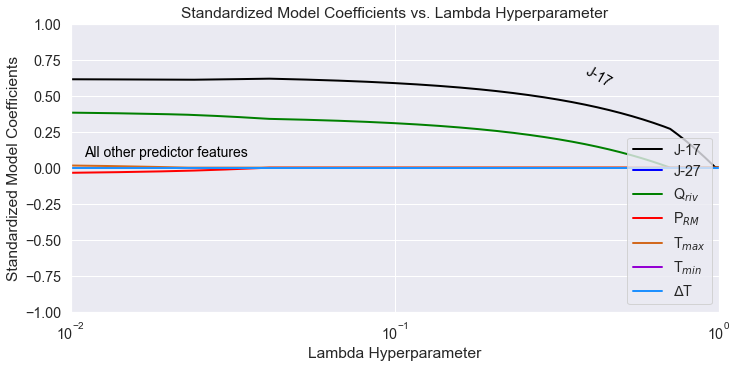

In [30]:
X = df_st.iloc[:, :-1].values
y = df_st.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73073)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

nbins = 1000                                             
lams = np.linspace(0.001, 1.0, nbins)                     
coefs = np.ndarray((nbins, 7))
index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                           
    lasso_reg.fit(X_train, y_train)                      
    coefs[index,:] = lasso_reg.coef_                       
    index = index + 1
    
color = ['black','blue','green',       'red',       'chocolate', 'darkviolet',  'dodgerblue']
label = ['J-17', 'J-27', r'Q$_{riv}$', 'P$_{RM}$',  'T$_{max}$', 'T$_{min}$',   '$\Delta$T']

plt.subplot(111)                                            
for ifeature in range(0,7):
    plt.semilogx(lams,coefs[:,ifeature], label=label[ifeature], c=color[ifeature], linewidth=2.0)
    
plt.text(0.38, .56, "J-17", fontsize=14, color='black', ha='left', rotation=-30) 
plt.text(0.011, .08, "All other predictor features", fontsize=14, color='black', ha='left', rotation=0) 

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); 
plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Standardized Model Coefficients')
plt.xlim(0.01,1); plt.ylim(-1, 1);  plt.legend(loc = 'lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)

#### The same lambda feature selection, but with index well J-17 removed to better visualize the other features

Number of training data = 17851 and number of testing data = 5951


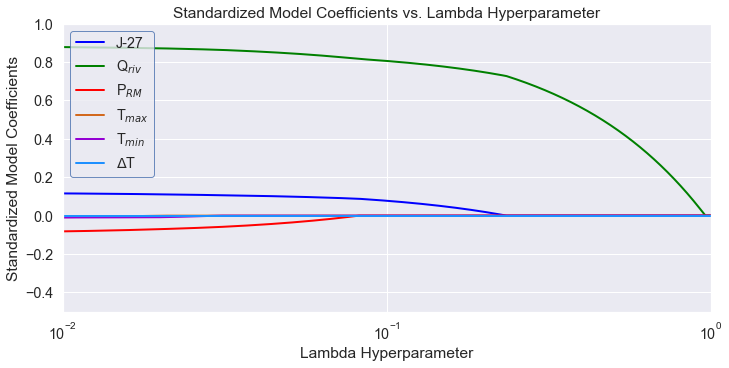

In [33]:
X = df_st.iloc[:, 1:-1].values
y = df_st.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73073)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

nbins = 1000                                              
lams = np.linspace(0.001, 1.0, nbins)                        
coefs = np.ndarray((nbins, 6))
index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                           
    lasso_reg.fit(X_train, y_train)                         
    coefs[index,:] = lasso_reg.coef_                        
    index = index + 1
    
color = ['blue','green',       'red',       'chocolate', 'darkviolet', 'dodgerblue']
label = ['J-27', r'Q$_{riv}$', 'P$_{RM}$', 'T$_{max}$', 'T$_{min}$', '$\Delta$T',  ]

plt.subplot(111)                                            
for ifeature in range(0,6):
    plt.semilogx(lams,coefs[:,ifeature], label=label[ifeature], c=color[ifeature], linewidth=2.0)

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); 
plt.xlabel('Lambda Hyperparameter'); 
plt.ylabel('Standardized Model Coefficients')
plt.xlim(0.01,1); plt.ylim(-0.5, 1);   

leg = plt.legend();leg.get_frame().set_edgecolor('b')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)

LASSO ranked the standardized features in the following order from best to worst: (1) J-17, (2) Q$_{riv}$, (3) J-27, (4) T$_{max}$, (5) $\Delta$T, (6) P$_{RM}$, and (7) T$_{min}$.  Index well J-17 is much more informative than the other features.  To better visualize the feature ranking through LASSO, J-17 was removed and the process was repeated.  The T$_{min}$ predictor feature shrinks to zero almost immediately.  This data-driven approach also ranks T$_{max}$ much higher than one would expect. 

### Overall Feature ranking:
From the metrics below, the feature ranking is as follows:
1. J-17
2. Q$_{riv}$
3. J-27
4. P$_{RM}$
5. T${max}$
6. T$_{min}$
7. $\Delta$T

Index well J-17 is the highest ranked feature in each of the metrics below.  Index well J-27 and Q$_{riv}$ ranked second or third depending on the metric, but Q$_{riv}$ was interpreted to be ranked second overall due to its large Pearson's correlation, Spearman rank correlation, and partial correlation, with J-27 as third.  Though the weather (P$_{RM}$, T$_{max}$, $\Delta$T, and T$_{min}$) data performed low relative to the river and well data, T$_{max}$ outperformed T$_{min}$, P$_{RM}$, and $\Delta$T in LASSO and performed higher than the other weather data according to Pearson's correlation and Spearman correlation.  The data-driven approach ranked T$_{max}$ higher than P$_{RM}$ in some metrics, but through expert knowledge, P$_{RM}$ has been ranked fourth because of its direct impact on aquifer recharge and Q$_{riv}$.  T$_{max}$ outperformed the remaining features and is ranked fifth.  $\Delta$T performed slightly better than T$_{min}$ and, therefore, $\Delta$T is sixth and T$_{min}$ is least important.

# Part II: Isotonic Regression for Springflow Prediction

Predictor features:
1. J-17: Bexar County index well, located 24 miles from Comal Springs (EAA)
2. J-27: Uvalde County index well, located 106 miles from Comal Springs (EAA)
3. Q$_{riv}$: Comal River discharge ($\frac{ft^3}{s}$) recorded on 15-minute intervals that were then averaged together (USGS)
4. T$_{max}$: maximum recorded daily temperature (NOAA)
5. T$_{min}$: minimum recorded daily temperature (NOAA)
6. $\Delta$ T: daily change in temperature (T$_{max}-$T$_{min}$) (NOAA)
7. P$_{RM}$: trailing rolling mean of preciptiation (t=3 days) (NOAA)

Response feature:
1. Q$_{spg}$: Comal Springs daily mean discharge (USGS)

##### Isotonic Regression Model Setup
Springflow discharge was predicted using J-17 as the single predictor feature through isotonic regression because J-17 was a much more important feature than the others in the dataset.  If all features were used to model springflow, there is a risk of multicollinearity and model instability.  Isotonic regression was selected as the predictive model because of its ability to capture the change in linear slope between J-17 and springflow.

$min \sum_{i=0}^{n} w_i(y_i - \hat{y}_i)^2$

under the constraint that: $y_0 \geq y_1 \geq \ldots y_n$


where: $w_i$ are positive weights, $y_i$ are real numbers, $\hat{y_i}$ are predictions  

In [53]:
import os                                                
import numpy as np                                          
import scipy.stats as st                                    
import pandas as pd                                         
import matplotlib.pyplot as plt                             
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Lasso
import seaborn as sns 
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
import pandas as pd
from itertools import repeat
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

### Using the same data as in Section I

In [54]:
df = pd.read_csv(os.path.join("..", "data", "ComalPrecipRolling.csv"))
df['datetime'] = pd.to_datetime(df["datetime"])


### Remove the outliers in the data

In [55]:
df = df[df["RvQ"] < 800]   # Truncate to remove outliers
df = df[df["DeltaT"] >= 0] # Truncate to remove outliers
df.describe().T

,count,mean,std,min,25%,50%,75%,max
J17Level,23802.0,663.104604,17.412985,612.51,6.509493e+02,664.700000,676.350000,703.3100
J27Level,23802.0,866.980272,16.240482,810.95,8.637000e+02,872.350000,877.417500,889.0500
RvQ,23802.0,281.172574,99.758576,5.50,2.180000e+02,290.000000,347.000000,793.0000
PRCP,23802.0,0.083458,0.275063,0.00,0.000000e+00,0.000000,0.018000,6.5025
TMAX,23802.0,78.120977,14.270323,17.00,6.900000e+01,80.000000,90.000000,109.0000
TMIN,23802.0,53.491681,15.224556,-1.00,4.100000e+01,56.000000,67.000000,84.0000
DeltaT,23802.0,24.629296,8.848741,0.00,1.900000e+01,24.000000,31.000000,69.0000
SpgQ,23802.0,276.218027,94.605254,0.00,2.150000e+02,290.000000,345.000000,513.0000
rolling_mean,23802.0,0.086917,0.200663,0.00,2.826443e-15,0.003333,0.075556,4.1800
RvSpgDiff,23802.0,0.062512,0.769795,0.00,0.000000e+00,0.000000,0.000000,16.0000


#### Determine number of isotonic constraints

To test if the model was overfit to the data, the mean squared error (MSE) and variance explained ($r^2$) were calculated and visualized for a range of isotonic constraints ($K$).  Both the MSE and $r^2$ become constant at approximately $K=15$.  However, any $K$ value between 10 and 30 results in approximately the same amount of variance explained (0.960 $< r^2 <$ 0.961).  It is important for water management to accurately predict springflow values during drought conditions when discharge values are low.   Therefore, in order to avoid overfit and capture the change in linear slope at small values of J-17, an isotonic constraint of $K=15$ was selected.

In [56]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

df_cv = shuffle(df)
X = df_cv["J17Level"]
y = df_cv["SpgQ"]

X = np.array(X)
y = np.array(y)

isotonic_constraint_list = np.linspace(2,30,10)
# X, y

kf = KFold(n_splits=5)
print(kf)
isotonic_constraint_list = np.linspace(2,30,10)
R2_ = np.zeros((5,10)); flag_1=0
MSE_= np.zeros((5,10)); flag_2=0

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for k in isotonic_constraint_list:
        X_predict = np.linspace(615, 700, k)
        iso_reg = IsotonicRegression()
        iso_reg.fit(X_train, y_train)
        y_predict = iso_reg.predict(X_predict)
        y_predict_test = np.interp(X_test, X_predict, y_predict, left=None, right=None, period=None)
        r2 = explained_variance_score(y_test, y_predict_test)
        mse = mean_squared_error(y_test, y_predict_test)
        R2_[flag_1, flag_2] = r2
        MSE_[flag_1, flag_2] = mse
        flag_2 = flag_2 +1
    flag_2 = 0
    flag_1 = flag_1 + 1

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 4761  4762  4763 ... 23799 23800 23801] TEST: [   0    1    2 ... 4758 4759 4760]
TRAIN: [    0     1     2 ... 23799 23800 23801] TEST: [4761 4762 4763 ... 9519 9520 9521]
TRAIN: [    0     1     2 ... 23799 23800 23801] TEST: [ 9522  9523  9524 ... 14279 14280 14281]
TRAIN: [    0     1     2 ... 23799 23800 23801] TEST: [14282 14283 14284 ... 19039 19040 19041]
TRAIN: [    0     1     2 ... 19039 19040 19041] TEST: [19042 19043 19044 ... 23799 23800 23801]


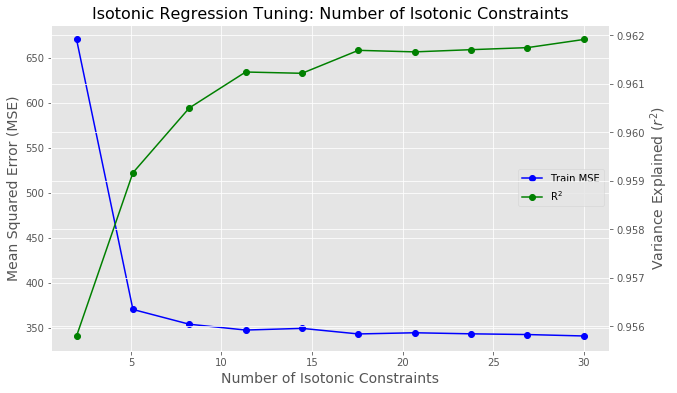

In [57]:
R2_mean = np.mean(R2_,axis=0)
MSE_mean = np.mean(MSE_,axis=0)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
lns1 = ax1.plot(isotonic_constraint_list, MSE_mean, label="Train MSE", color='blue', marker='o')
lns2 = ax2.plot(isotonic_constraint_list, R2_mean , label="R$^2$", color='green', marker='o')

ax1.set_title("Isotonic Regression Tuning: Number of Isotonic Constraints", size=16)
ax1.set_ylabel("Mean Squared Error (MSE)", size=14)
ax2.set_ylabel("Variance Explained ($r^2$)", size=14)
ax1.set_xlabel("Number of Isotonic Constraints", size=14)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

#### Simplify the code and set X and y values for the isotonic regression (J-17 index well and springflow discharge)

In [58]:
X = df.iloc[:, 1]
y = df.iloc[:, -3]

#### Isotonic Model

The isotonic regression produced an $r^2$ of 0.957, meaning that 95.7\% of the variance in springflow can be explained by index well J-17.  When comparing the measured springflow to the modeled springflow ($y-\hat{y}_{J17})$, the mean was 0.52 and the standard deviation is 18.43 with a minimum value of -65 and a maximum value of 84.  When measured and modeled data are plotted, they result is highly linear with a slope of 0.96.  

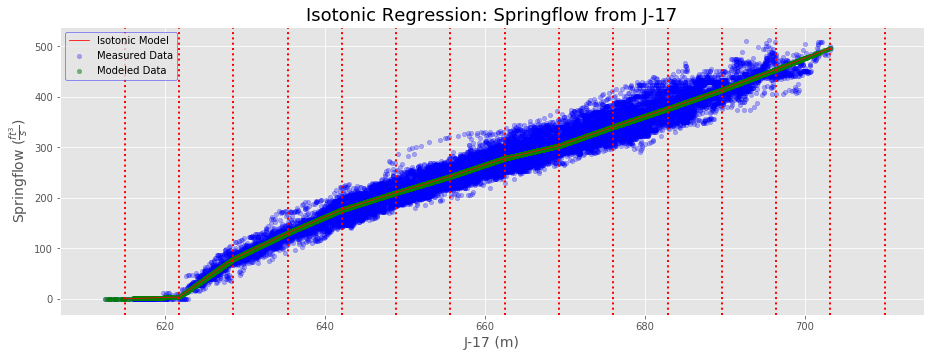

In [59]:
iso_reg = IsotonicRegression().fit(X, y)
X_predict = np.linspace(615,710,15)
y_predict = iso_reg.predict(X_predict)
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

# Plot test predictions
plt.subplot(111)
plt.scatter(X, y,  color='blue', s = 20, alpha = 0.3, label='Measured Data')
plt.scatter(X, y_predict_test,  color='green', s = 20, alpha = 0.5, label='Modeled Data')
plt.plot(X_predict, y_predict, color='red', linewidth=.8, label='Isotonic Model')
for threshold in X_predict:
    plt.axvline(threshold, color='red', linewidth=2, linestyle=':', alpha = 1)
plt.title('Isotonic Regression: Springflow from J-17', size=18); 
plt.xlabel('J-17 (m)', size=14); plt.ylabel(r'Springflow ($\frac{ft^3}{s}$)', size=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
leg = plt.legend()
leg.get_frame().set_edgecolor('b')

In [60]:
isotonic_constraint_list = np.linspace(2,30,10)
r2 = []

for k in isotonic_constraint_list:
    X_predict = np.linspace(615, 700, k)
    iso_reg = IsotonicRegression().fit(X, y)
    y_predict = iso_reg.predict(X_predict)
    y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)
    r2.append(explained_variance_score(y, y_predict_test))
    
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

##### Modeled vs. Measured Springflow

There is a very clear, linear slope when comparing the measured springflow to what was calculated by the model.

(-10, 515)

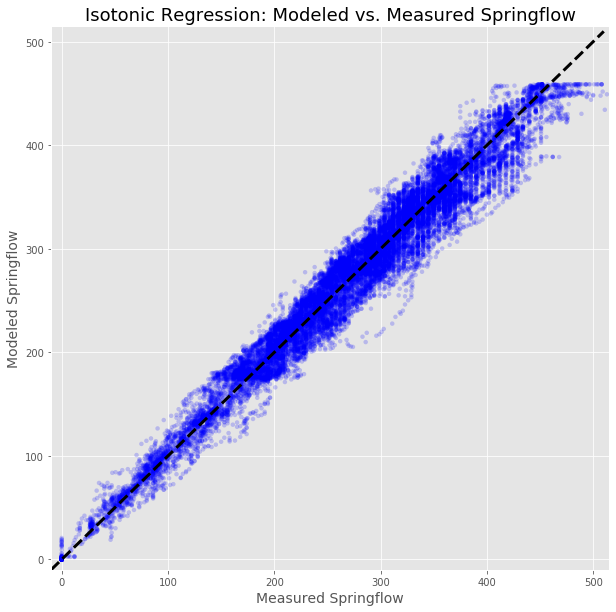

In [61]:
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(y, y_predict_test, alpha=0.2, edgecolor='', color='blue', s=20)
plt.plot(np.linspace(-10,510,10), np.linspace(-10,510,10), '--k', linewidth=3)
plt.title('Isotonic Regression: Modeled vs. Measured Springflow', size=18); 
plt.xlabel('Measured Springflow', size=14); plt.ylabel(r'Modeled Springflow', size=14)
plt.xlim(-10, 515); plt.ylim(-10,515)

### Residuals

Below, we add the model outputs and residuals to the main dataframe, then visualize the residuals.

In [62]:
df["Spg_IsoPred"] = y_predict_test
# df["Spg_IsoPred"] = df["Spg_IsoPred"].astype(int)
df["Residual"] = df["SpgQ"] - df["Spg_IsoPred"]
df["Corrected"] = df["Spg_IsoPred"]
df["Corrected"] = np.where(df["Spg_IsoPred"]>df["RvQ"], df["RvQ"], df["Spg_IsoPred"])
df["CorrRes"] = df["SpgQ"] - df["Corrected"]

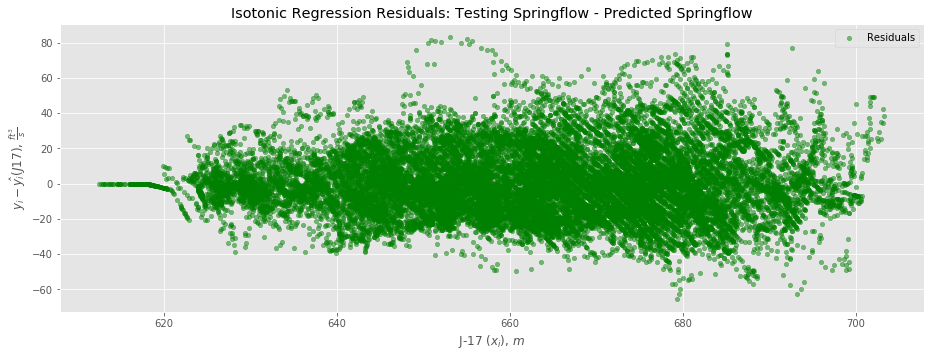

In [63]:
residuals = y-y_predict_test
df["Residual"] = residuals
df["Spg_IsoPred"] = y_predict_test

plt.subplot(111)
plt.scatter(X, residuals,  color='green', s = 20, alpha = 0.5, label='Residuals')
plt.title('Isotonic Regression Residuals: Testing Springflow - Predicted Springflow'); 
plt.xlabel(r'J-17 ($x_i$), $m$'); plt.ylabel(r'$y_i-\hat{y_i}(J17)$, $\frac{ft^3}{s}$')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

### Calculate the min, max, P25, and P75 in the data

In [64]:
X_predict0 = X_predict.tolist()
X_predict0 = [0]+X_predict0
X_predict = list(X_predict)

In [65]:
mins = [];maxs = [];P1s  = [];P5s  = [];P10s = [];P25s = [];P35s = [];P50s = [];P65s = [];P75s = [];
P90s = [];P95s = []; P99s = [];preds_in_df = []

mins_ = []
maxs_ = []

temp_df = df[df["J17Level"] <= X_predict0[1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[0], len(temp_df)))
P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

for i in range(1, len(X_predict0)-1):
    temp_df = df[(df["J17Level"] > X_predict0[i]) & (df["J17Level"] <= X_predict0[i+1])]
    temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
    preds_in_df.extend(repeat(X_predict0[i+1], len(temp_df)))
    P1  = np.percentile(temp_df["diff"], 1);  P1s.append(P1)
    P5  = np.percentile(temp_df["diff"], 5);  P5s.append(P5)
    P10 = np.percentile(temp_df["diff"], 10); P10s.append(P10)
    P25 = np.percentile(temp_df["diff"], 25); P25s.append(P25)
    P50 = np.percentile(temp_df["diff"], 50); P50s.append(P50)
    P75 = np.percentile(temp_df["diff"], 75); P75s.append(P75)
    P90 = np.percentile(temp_df["diff"], 90); P90s.append(P90)
    P95 = np.percentile(temp_df["diff"], 95); P95s.append(P95)
    P99 = np.percentile(temp_df["diff"], 99); P99s.append(P99)
    P35 = np.percentile(temp_df["diff"], 35); P35s.append(P35)
    P65 = np.percentile(temp_df["diff"], 65); P65s.append(P65)
    mins.append(temp_df["diff"].min())
    maxs.append(temp_df["diff"].max())
    mins_.extend(repeat(P25, len(temp_df)))
    maxs_.extend(repeat(P75, len(temp_df)))

temp_df = df[df["J17Level"] > X_predict0[-1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[-1], len(temp_df)))

P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

In [66]:
# df.sort_values(by='J17Level', inplace=True)
df["Xpred"] = preds_in_df
df["Xpred"] = df["Xpred"].astype(int)

new_ls = np.zeros(len(preds_in_df))
new_ls = np.digitize(x=df['J17Level'], bins=X_predict0, right=False)
df["XpredBin"] = new_ls
df['Xpred'] = df.apply(lambda i: X_predict0[i['XpredBin']-1],axis=1)
df["Xpred"] = df["Xpred"].astype(int)

df["Mins"] = mins_
df["Maxs"] = maxs_

### Test for Conditional Independence of Isotonic Residual

To assess how well the residuals from the isotonic regression could be explained by the remaining predictor features, the conditional probability distributions between each predictor feature (J-27, Q$_{riv}$, T$_{max}$, T$_{min}$, $\Delta$T, and P$_{RM}$) and the isotonic residual ($y-\hat{y}_{J17}$) were examined.  The marginal and joint probability distribution functions provide evidence that there exists conditional independence between features, meaning that the features do not explain the signal from the isotonic regression residuals.  

#### Visualize the joint distributions for all predictor features

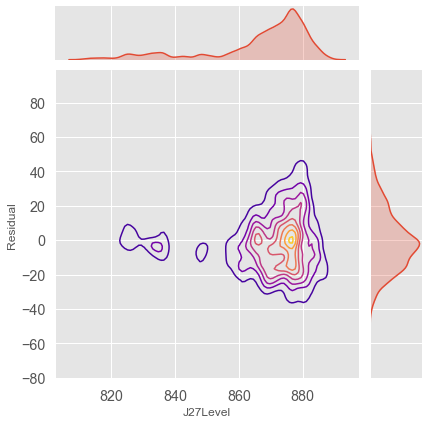

In [51]:
cmap = plt.cm.plasma

sns.jointplot(df['J27Level'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

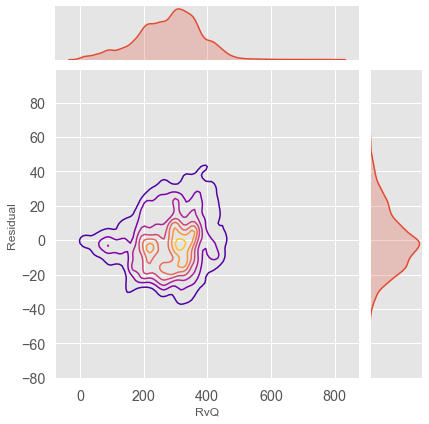

In [52]:
ax = sns.jointplot(df['RvQ'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

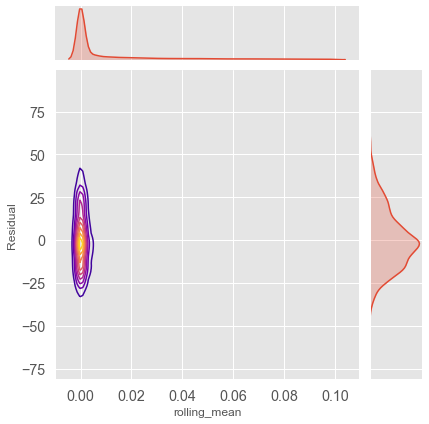

In [53]:
df2 = df[df["rolling_mean"] < 0.1] # to better visualize the distribution
ax = sns.jointplot(df2['rolling_mean'], df2['Residual'], df2, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

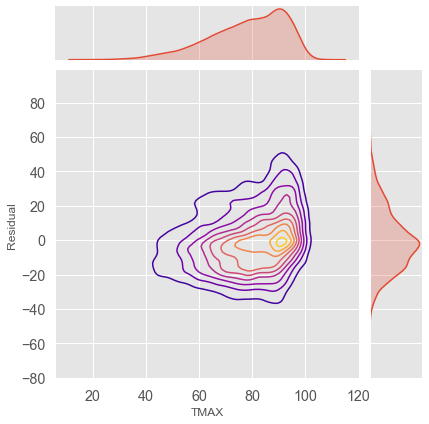

In [54]:
ax = sns.jointplot(df['TMAX'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

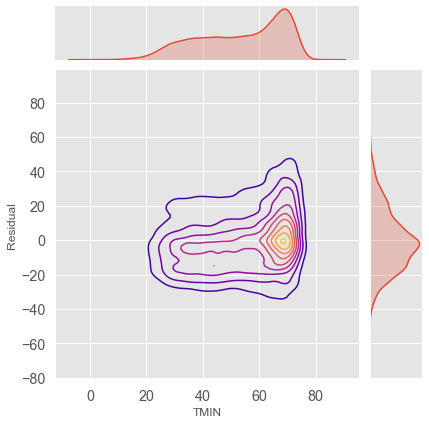

In [55]:
ax = sns.jointplot(df['TMIN'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels=10, cmap=plt.cm.plasma, shade_lowest = True);

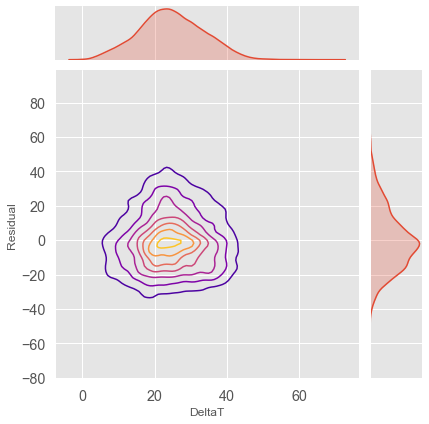

In [56]:
ax = sns.jointplot(df['DeltaT'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

#### Visualize the Conditional Distributions

Most of the P50 lines in the figures below are relatively flat, indicating conditional independence.  There is some fluctuation towards the large values in some of the figures, but this could represent non-typical natural events such as large storms or floods.  

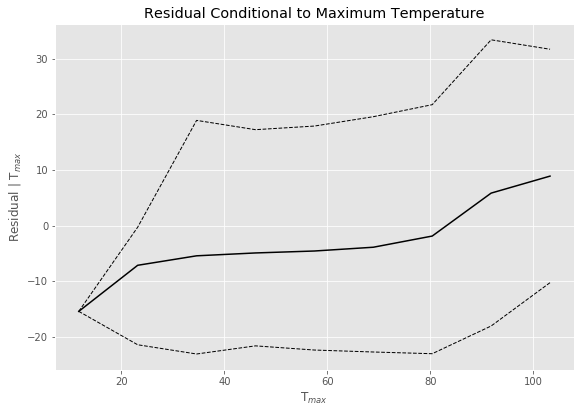

In [16]:
TMAX_bins = np.linspace(6,109, 10)          
TMAX_centroids = np.linspace((TMAX_bins[0]+TMAX_bins[1])*0.5,(TMAX_bins[8]+TMAX_bins[9])*0.5,9)
df['TMAX_bins'] = pd.cut(df['TMAX'], TMAX_bins, labels = TMAX_centroids) 

cond_exp = df.groupby('TMAX_bins')['Residual'].mean()
cond_P90 = df.groupby('TMAX_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('TMAX_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(TMAX_centroids,cond_exp,color='black')
plt.plot(TMAX_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(TMAX_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'T$_{max}$')
plt.ylabel(r'Residual | T$_{max}$')
t = plt.title('Residual Conditional to Maximum Temperature')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

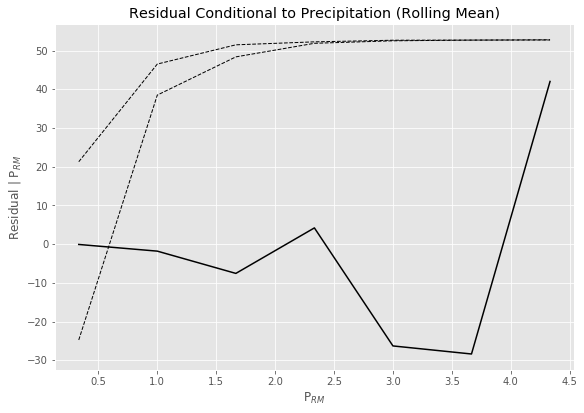

In [17]:
rolling_mean_bins = np.linspace(0,6, 10)          
rolling_mean_centroids = np.linspace((rolling_mean_bins[0]+rolling_mean_bins[1])*0.5,(rolling_mean_bins[8]+rolling_mean_bins[9])*0.5,9)
df['rolling_mean_bins'] = pd.cut(df['rolling_mean'], rolling_mean_bins, labels = rolling_mean_centroids) 

cond_exp = df.groupby('rolling_mean_bins')['Residual'].mean()
cond_P90 = df.groupby('rolling_mean_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('rolling_mean_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(rolling_mean_centroids,cond_exp,color='black')
plt.plot(rolling_mean_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(rolling_mean_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'P$_{RM}$')
plt.ylabel(r'Residual | P$_{RM}$')
t = plt.title('Residual Conditional to Precipitation (Rolling Mean)')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

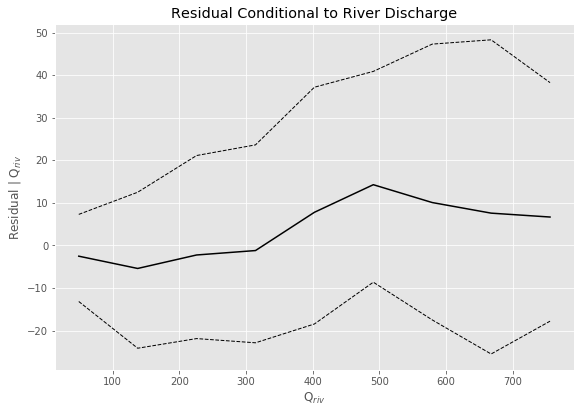

In [18]:
RvQ_bins = np.linspace(5, 800, 10)          
RvQ_centroids = np.linspace((RvQ_bins[0]+RvQ_bins[1])*0.5,(RvQ_bins[8]+RvQ_bins[9])*0.5,9)
df['RvQ_bins'] = pd.cut(df['RvQ'], RvQ_bins, labels = RvQ_centroids) 

cond_exp = df.groupby('RvQ_bins')['Residual'].mean()
cond_P90 = df.groupby('RvQ_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('RvQ_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(RvQ_centroids,cond_exp,color='black')
plt.plot(RvQ_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(RvQ_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'Q$_{riv}$')
plt.ylabel(r'Residual | Q$_{riv}$')
t = plt.title('Residual Conditional to River Discharge')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

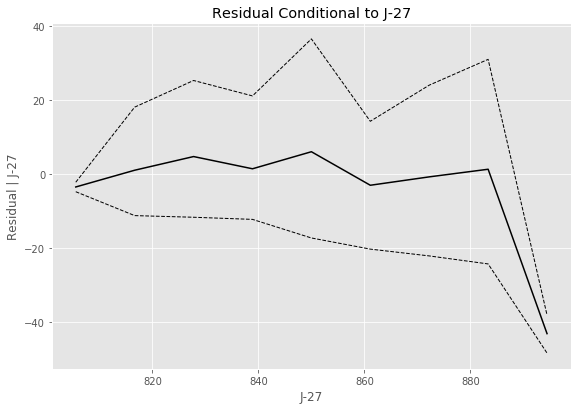

In [19]:
J27_bins = np.linspace(800, 900, 10)          
J27_centroids = np.linspace((J27_bins[0]+J27_bins[1])*0.5,(J27_bins[8]+J27_bins[9])*0.5,9)
df['J27_bins'] = pd.cut(df['J27Level'], J27_bins, labels = J27_centroids) 

cond_exp = df.groupby('J27_bins')['Residual'].mean()
cond_P90 = df.groupby('J27_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('J27_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(J27_centroids,cond_exp,color='black')
plt.plot(J27_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(J27_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'J-27')
plt.ylabel(r'Residual | J-27')
t = plt.title('Residual Conditional to J-27')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

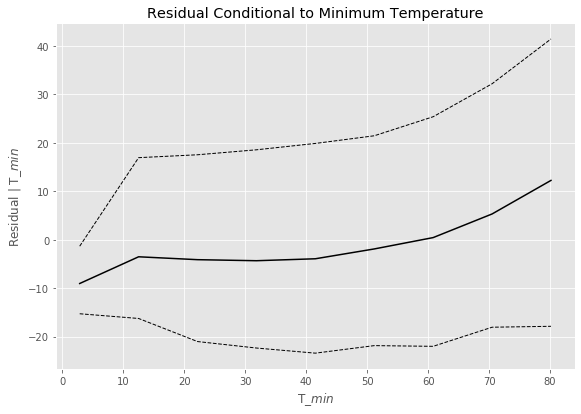

In [20]:
TMIN_bins = np.linspace(-2, 85, 10)          
TMIN_centroids = np.linspace((TMIN_bins[0]+TMIN_bins[1])*0.5,(TMIN_bins[8]+TMIN_bins[9])*0.5,9)
df['TMIN_bins'] = pd.cut(df['TMIN'], TMIN_bins, labels = TMIN_centroids)  

cond_exp = df.groupby('TMIN_bins')['Residual'].mean()
cond_P90 = df.groupby('TMIN_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('TMIN_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(TMIN_centroids,cond_exp,color='black')
plt.plot(TMIN_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(TMIN_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'T_${min}$')
plt.ylabel(r'Residual | T_${min}$')
t = plt.title('Residual Conditional to Minimum Temperature')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

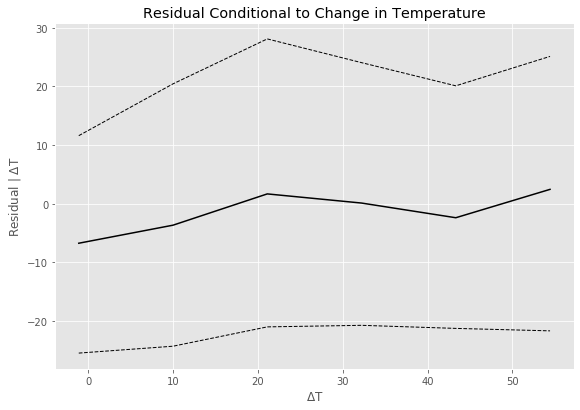

In [21]:
DeltaT_bins = np.linspace(-40, 60, 10)          
DeltaT_centroids = np.linspace((DeltaT_bins[0]+DeltaT_bins[1])*0.5,(DeltaT_bins[8]+DeltaT_bins[9])*0.5,9)
df['DeltaT_bins'] = pd.cut(df['DeltaT'], DeltaT_bins, labels = DeltaT_centroids) 
   
cond_exp = df.groupby('DeltaT_bins')['Residual'].mean()
cond_P90 = df.groupby('DeltaT_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('DeltaT_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(DeltaT_centroids,cond_exp,color='black')
plt.plot(DeltaT_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(DeltaT_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'$\Delta$T')
plt.ylabel(r'Residual | $\Delta$T')
t = plt.title('Residual Conditional to Change in Temperature')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

### Violin Plot

Violin plots were generated to visualize the conditional statistics with the left side (low) of each violin being less than the P50 value of the residual and the right side (high) being greater than or equal to the P50 value.  The P50 value of the high and low residuals are all very close except for T$_{min}$ and T$_{max}$.  When the P25, P50, and P75 values for both the low and high residuals, indicating no conditional dependence exists between the predictor features and the isotonic residual and further modeling will likely not result in improved predictive accuracy.  

(-8, 8)

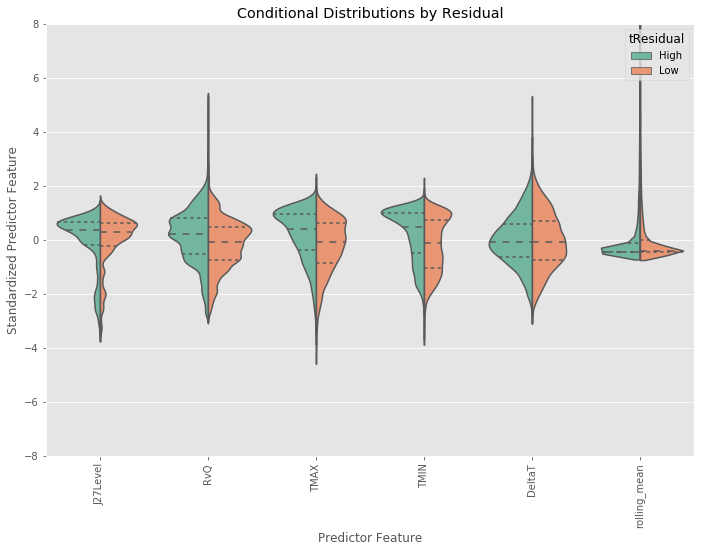

In [22]:
df['tResidual'] = np.where(df['Residual']>= -1, 'High', 'Low') # make a high and low production categorical feature

x = df[['J27Level', "RvQ", "TMAX", "TMIN", "DeltaT", "rolling_mean"]]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([df['tResidual'],x_stand.iloc[:,0:6]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="tResidual",var_name="Predictor Feature",value_name='Standardized Predictor Feature') 

plt.subplot(111)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tResidual", data=x,split=True, 
               inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Residual')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.ylim(-8,8)

### Feature Importances

Feature ranking:
1. feature 0 (0.376569)
2. feature 1 (0.304112)
3. feature 2 (0.138824)
4. feature 5 (0.069991)
5. feature 3 (0.064567)
6. feature 4 (0.045937)


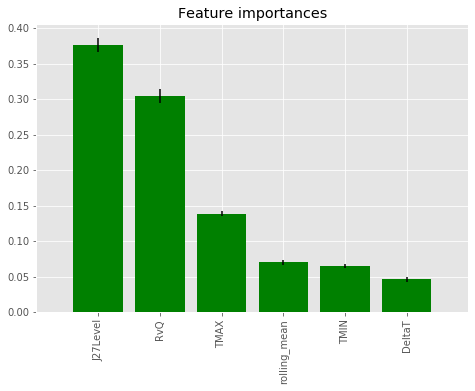

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[2,3,5,6,7, 9]]              # separate DataFrames for predictor and response features
y = df["Residual"]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)

### Mutual Information

According to the mutual information, index well J-27 and Q$_{riv}$ were the two most informative features in understanding the residuals.  The remaining predictor features (T$_{max}$, T$_{min}$, $\Delta$T, and P$_{RM}$) each had a mutual information score below 0.07 and were not important in predicting the springflow residual. 

[0.29970363 0.23913085 0.06405225 0.04572755 0.01158732 0.01888405]
Feature ranking:
1. feature 0 (0.376569)
2. feature 1 (0.304112)
3. feature 2 (0.138824)
4. feature 3 (0.064567)
5. feature 5 (0.069991)
6. feature 4 (0.045937)


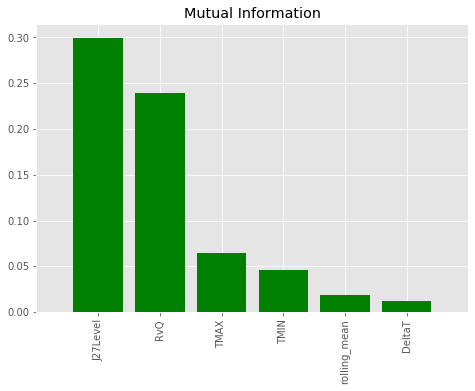

In [25]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score

x = df.iloc[:,[2,3,5,6,7, 9]]              # separate DataFrames for predictor and response features
y = df["Residual"]

# mi = mutual_info_regression(x,np.ravel(y_encoded)) # calculate mutual information
mi = mutual_info_regression(x,y) # calculate mutual information

print(mi)
# mi /= np.max(mi)                          # calculate relative mutual information
indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)

### Attempted model boosting with multiple linear regression and naive Bayes classification

Even though the figures above indicate conditional independence, additional models were run on the isotonic residuals in hopes of explaining more of the variance.  A multiple linear regression and naive Bayes classifier were used to create a boosting model in an attempt to improve upon the isotonic regression.  The multiple linear regression and naive Bayes classifier did not succeed in improving upon the isotonic regression, as was suggested by the conditional independence metrics.  With an $r^2$ of 0.957, it can be argued that the isotonic regression is a strong model and there is limited remaining signal to capture.  


### Uncertainty in Model Prediction:

The data was binned by isotonic constraint (K=15) and summary statistics were calculated for each bin.  

The box plot indicates the range in predicted values in each isotonic constraint 'bin'.  There is a 50\% chance of the residual from the isotonic regression falling inside the boundaries of the boxes.  The bottom and top of the boxes represent the P25 and P75 values.  The interquartile range (IQR = 1.5 x (P25 + P75)) is represented by the whiskers, or tips extending from the boxes.  The range in predictions is very small for the low values of isotonic constrints, which displays that the model performs well during drought conditions.  The isotonic constraint 'bin' that represents the largest values of index well J-17 has the largest error range, indicating that the physics of the system are not as well captured through the isotonic regression during extremely wet periods.  These events are much more rare and therefore difficult to predict.  Additionally, it was more of a priority to accurately predict springflow values during periods of drought and the drought stages set by the Edwards Aquifer Authority.

A line was drawn at +10 and -10 to indicate the range of accuracy of the model along all values of J-17

Text(0, 0.5, 'Residual')

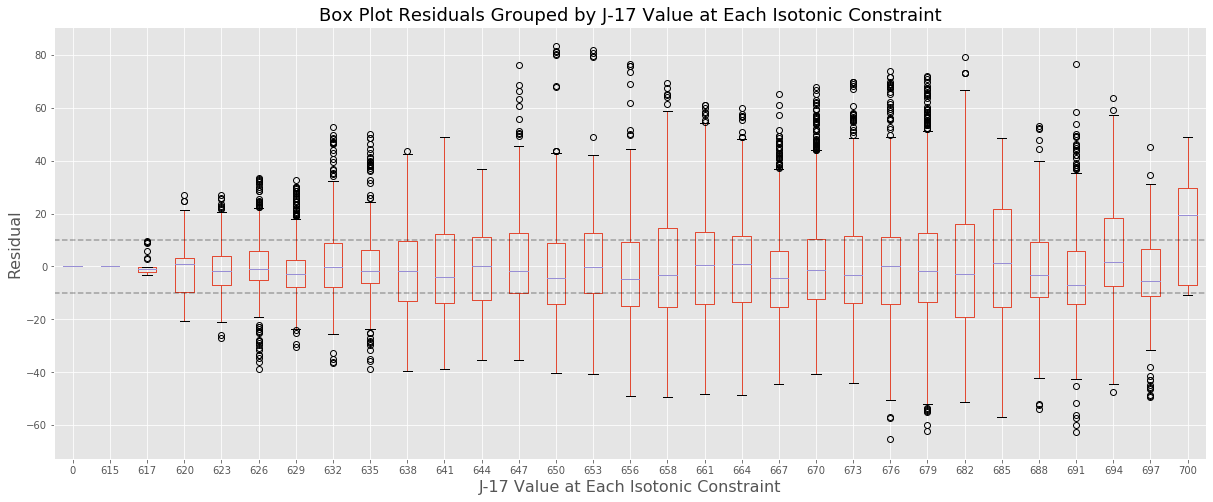

In [67]:
j = df.boxplot(column='Residual', by='Xpred', figsize=(20,8));

plt.axhline(10,  color='black', linestyle='--', alpha=0.3)
plt.axhline(-10, color='black', linestyle='--', alpha=0.3)
plt.suptitle("")
plt.title("Box Plot Residuals Grouped by J-17 Value at Each Isotonic Constraint", size=18)
plt.xlabel("J-17 Value at Each Isotonic Constraint", size=16)
plt.ylabel("Residual", size=16)

### Applications with Theory-Guided Data Science: Model Output Post-Processing

The predicted springflow values were corrected using theory-guided output post-processing to meet the condition that Q$_{spg} \leq$ Q$_{riv}$.  In Comal Springs, Q$_{spg}$ is never greater than Q$_{spg}$ because the springs directly feed the river, though river discharge is often larger than springflow during precipitation events.  If the predicted springflow value was larger than the daily mean river discharge, springflow was truncated and set equal to river discharge.  Additionally, if the Q$_{spg}$ prediction was less than 0 cfs, the prediction was automatically increased and set equal to 0 cfs.  The accuracy of the model was calculated by determining whether an observation falls within the P25 to P75 range (between the bottom and top of each box in the boxplot).  If the observation fell within that range, then it was correct.  If it fell outside the range, then it was incorrect.  This calculation was done prior to and after truncating springflow to fall within the physical range.  These were both calculated for each of the drought stages as well, using index well J-17 as the proxy.  The predictive accuracy increases as the drought condition worsens for both methods, but there exists a clear increase in predictive accuracy when the springflow value is corrected. 

In [72]:
df["SpgMins"] = df["Mins"] + df["Spg_IsoPred"]
df["SpgMaxs"] = df["Maxs"] + df["Spg_IsoPred"]
# df["SpgMins"] = df["SpgMins"].astype(int)
# df["SpgMaxs"] = df["SpgMaxs"].astype(int)
df['Within'] = 0
df["Within"].loc[(df["SpgQ"].between(df["SpgMins"], df["SpgMaxs"]))] = 1

# Correction
df["SpgMinsCorr"] = df["Mins"] + df["Corrected"]
df["SpgMaxsCorr"] = df["Maxs"] + df["Corrected"]
df["SpgMinsCorr"] = df["SpgMins"].astype(int)
df["SpgMaxsCorr"] = df["SpgMaxs"].astype(int)
df["Within"].loc[(df["Corrected"].between(df["SpgMinsCorr"], df["SpgMaxsCorr"]))] = 1

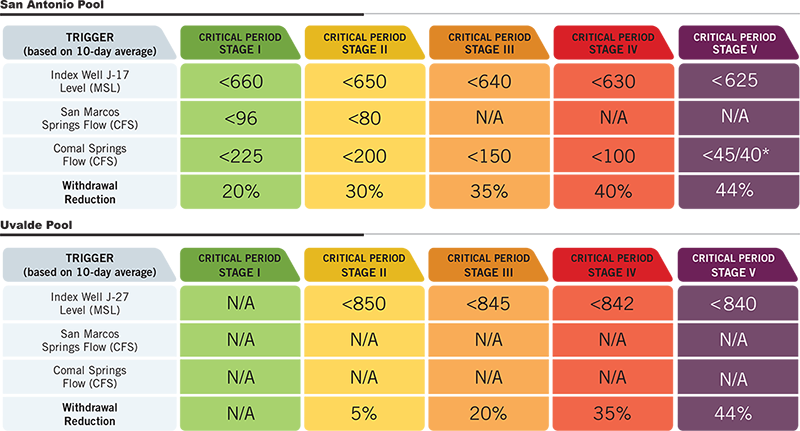

# Results:

### With Springflow correction:
(First number represents total amount of data in each drought stage, second number is number correct, aka fell within the P25-P75 range - same as box range.  These were calculated manually from the data)
<br>
<br>

Drought stage 1: 4526, 3696 (81.6%)

Drought stage 2: 2517, 2076 (82.5%)

Drought stage 3: 1089, 943  (86.6%)

Drought stage 4: 384,  340  (88.5%)

Drought stage 5: 109,  104  (95.4%)


### Without Springflow correction: 
Drought stage 1: 4526, 2397 (52.9%)

Drought stage 2: 2517, 1320 (52.4%)

Drought stage 3: 1089, 601 (55.1%)

Drought stage 4: 384,  227 (59.1%)

Drought stage 5: 109,  83 (76.1%)


### Summary:

This model is very accurate when springflow is corrected, meaning that there is a high chance of the predicted value falling within +/- 10 cfs of the actual springflow value.  When the region experiences a drought and J-17 level starts decreasing, the model makes more accurate predictions, which is what is most useful to water management.  It is less essential to know how much water is coming from the springs when they are heavily flowing.  



# Recommendation/Future Work:

This predictive model performs very well.  Future work is to create a forecasting model.  This includes pulling in real-time daily data of the Comal River discharge and the level at J-17 to generate a prediction and then post-process the result.  This workflow will be improved upon as part of my thesis work and then introduced to the USGS and EAA as an alternative to their current method of springflow estimation.  This is a faster method that requires no manual work, whereas their current method takes time each day and manual interpretation.  Additionally, because the current method of springflow estimation involves uncertainties through averaging, this method I've produced is arguably equally correct.  